In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
#np.random.seed(123)

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
samples = pd.read_csv('../data/TCGA/rna-seq_adeno/meta/gdc_sample_sheet.2020-01-27.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['Project ID'].value_counts()

TCGA-LUSC    301
TCGA-LUAD    287
CPTAC-3      209
Name: Project ID, dtype: int64

Samples with RNAseq adjacent normal tissue

In [4]:
samples['Sample Type'].value_counts()

Primary Tumor                               558
Solid Tissue Normal                         206
Primary Tumor, Primary Tumor                 29
Solid Tissue Normal, Solid Tissue Normal      4
Name: Sample Type, dtype: int64

In [5]:
samples.loc[samples['Sample Type']=='Primary Tumor, Primary Tumor', 'Sample Type'] = 'Primary Tumor'
samples.loc[samples['Sample Type']=='Solid Tissue Normal, Solid Tissue Normal', 'Sample Type'] = 'Solid Tissue Normal'

In [6]:
samples['Sample Type'].value_counts()

Primary Tumor          587
Solid Tissue Normal    210
Name: Sample Type, dtype: int64

In [7]:
# all cases with adjacent normal tissue
cases = samples[samples['Sample Type']=='Solid Tissue Normal']['Case ID']

In [8]:
# disparity in cases
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()
samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') 
        & (samples['data']=='FPKM')]['Case ID'].nunique()

176

210

In [9]:
# divide, join, subset
case_tumor = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Primary Tumor') & 
                     (samples['data']=='FPKM')]
case_norm = samples[(samples['Case ID'].isin(cases)) & (samples['Sample Type']=='Solid Tissue Normal') & 
                    (samples['data']=='FPKM')]
cases = pd.merge(case_tumor['Case ID'], case_norm['Case ID'])['Case ID']
cases.shape

(187,)

In [10]:
case_tumor = case_tumor[case_tumor['Case ID'].isin(cases)]
case_norm = case_norm[case_norm['Case ID'].isin(cases)]
cases = pd.concat([case_tumor, case_norm])

In [11]:
case_tumor.shape
case_norm.shape
cases.shape

(187, 9)

(176, 9)

(363, 9)

## Map Ensembl genes to Proteins

In [12]:
id_map = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/map_ensembl_uniprot.csv")
reviewed_proteins = pd.read_csv("/srv/home/wconnell/keiser/data/uniprot_mapping_ids/TCGA_rnaseq_uniprot_features.tab.gz", sep="\t")
proteins = pd.merge(id_map, reviewed_proteins, left_on='UNIPROT_ID', right_on='Entry name')
proteins['hgnc'] = [gene.split(";")[0] for gene in proteins['Gene names  (primary )']]
proteins.shape

(18842, 22)

## Dataset Prep

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = 'Sample Type'
cases[target] = cases[target].astype('category')

train, test = train_test_split(cases)
train[target].value_counts()
test[target].value_counts()

Primary Tumor          140
Solid Tissue Normal    132
Name: Sample Type, dtype: int64

Primary Tumor          47
Solid Tissue Normal    44
Name: Sample Type, dtype: int64

In [14]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

classes = {key:val for val,key in enumerate(train[target].cat.categories.values)}
classes

Cuda is available: True


{'Primary Tumor': 0, 'Solid Tissue Normal': 1}

In [15]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_adeno/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target, norm=False)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target, norm=False)

scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

#### Subset gene data to annotated proteins

In [16]:
assert np.array_equal(train_dataset.data.columns, test_dataset.data.columns)
parsed_cols = [ens[0] for ens in train_dataset.data.columns.str.split(".")]

train_dataset.data.columns, test_dataset.data.columns = parsed_cols, parsed_cols
protein_overlap_idx = np.isin(train_dataset.data.columns, proteins['ENSEMBL_ID'].values)

train_dataset.data = train_dataset.data.loc[:,protein_overlap_idx]
test_dataset.data = test_dataset.data.loc[:,protein_overlap_idx]

#### Write out test set for DE analysis

In [17]:
pd.to_pickle(test_dataset.data, "../data/tmp/test_dataset.pkl.gz")

In [18]:
map_cond = []
for label in test_dataset.labels:
    if label == test_dataset.labels_dict['Primary Tumor']:
        map_cond.append('Primary Tumor')
    elif label == test_dataset.labels_dict['Solid Tissue Normal']:
        map_cond.append('Solid Tissue Normal')

In [19]:
meta = pd.DataFrame({'label':test_dataset.labels,
                    'condition':map_cond},
                    index=test_dataset.data.index)
meta.to_pickle("../data/tmp/test_dataset_meta.pkl.gz")

## Siamese Network

In [20]:
# Step 1 set up dataloader
root_dir = "../data/TCGA"
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
# print training metrics every log_interval * batch_size
log_interval = 30

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=18812, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [21]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/272 (0%)]	Loss: 0.308882
Train: [240/272 (88%)]	Loss: 0.217741
Epoch: 1/20. Train set: Average loss: 0.2034
Epoch: 1/20. Validation set: Average loss: 0.0282
Train: [0/272 (0%)]	Loss: 0.067913
Train: [240/272 (88%)]	Loss: 0.021193
Epoch: 2/20. Train set: Average loss: 0.0210
Epoch: 2/20. Validation set: Average loss: 0.0192
Train: [0/272 (0%)]	Loss: 0.015358
Train: [240/272 (88%)]	Loss: 0.009151
Epoch: 3/20. Train set: Average loss: 0.0088
Epoch: 3/20. Validation set: Average loss: 0.0149
Train: [0/272 (0%)]	Loss: 0.001816
Train: [240/272 (88%)]	Loss: 0.006521
Epoch: 4/20. Train set: Average loss: 0.0059
Epoch: 4/20. Validation set: Average loss: 0.0144
Train: [0/272 (0%)]	Loss: 0.001226
Train: [240/272 (88%)]	Loss: 0.003991
Epoch: 5/20. Train set: Average loss: 0.0036
Epoch: 5/20. Validation set: Average loss: 0.0144
Train: [0/272 (0%)]	Loss: 0.000202
Train: [240/272 (88%)]	Loss: 0.002916
Epoch: 6/20. Train set: Average loss: 0.0027
Epoch: 6/20. Validation set: Average loss:

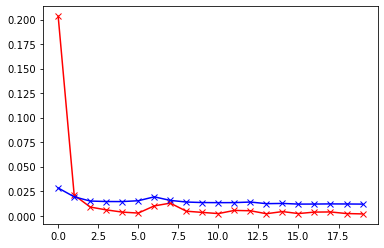

In [22]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

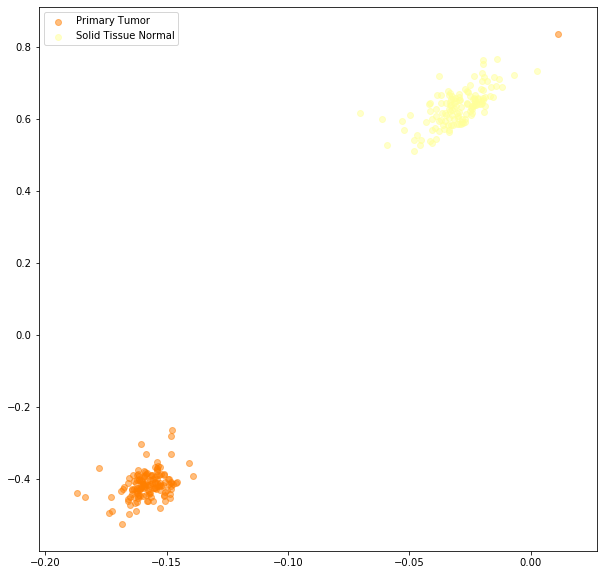

In [23]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset.labels_dict)

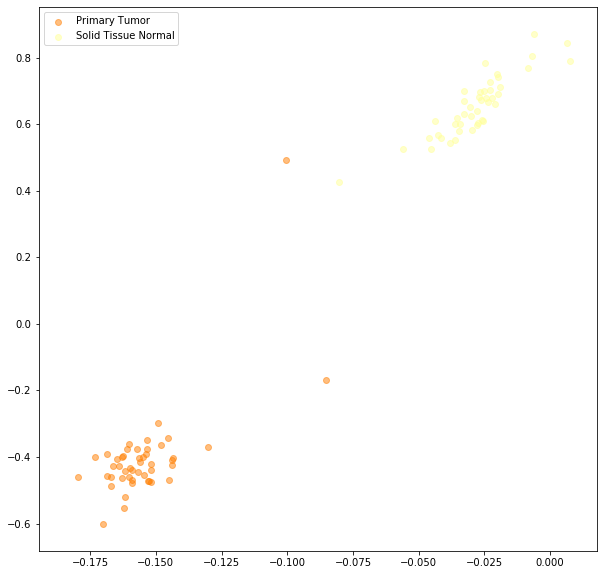

In [24]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset.labels_dict)

## Integrated Gradients
Test completeness axiom through comparison of different baselines

"Integrated gradients satisfy an
axiom called completeness that the attributions add up to
the difference between the output of F at the input x and
the baseline x'."

In [25]:
import copy
from captum.attr import LayerActivation
from captum.attr import IntegratedGradients

In [26]:
def attribution_pairs(SiameseTCGA, exp, ctrl):
    # subset different samples
    negative_pairs = np.array(SiameseTCGA.test_pairs)
    negative_pairs = negative_pairs[negative_pairs[:,2] == 0]
    # map labels to integers
    ctrl = siamese_test_dataset.labels_dict[ctrl]
    exp = siamese_test_dataset.labels_dict[exp]
    # ordered indices of samples
    ctrl_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[ctrl])]
    exp_data = [idx for pair in negative_pairs[:, :2] for idx in pair if np.isin(idx, SiameseTCGA.label_to_indices[exp])]
    # data
    ctrl_data = Variable(SiameseTCGA.test_data[ctrl_data], requires_grad=True)
    exp_data = Variable(SiameseTCGA.test_data[exp_data], requires_grad=True)
    return ctrl_data, exp_data

# IG with Control vector

In [27]:
ctrl_data, exp_data = attribution_pairs(siamese_test_dataset, exp='Primary Tumor', ctrl='Solid Tissue Normal')

In [28]:
from torch.nn import PairwiseDistance
pdist = PairwiseDistance(p=2)
pdist

PairwiseDistance()

In [29]:
ig = IntegratedGradients(model.get_dist)

In [30]:
torch.cuda.empty_cache()

## Healthy as baseline

In [31]:
attr, delta = ig.attribute(exp_data.cuda(), ctrl_data.cuda(), target=None, n_steps=50, return_convergence_delta=True,
                          additional_forward_args=(ctrl_data.cuda(), pdist))
attr = attr.cpu().detach().numpy()
delta

tensor([ 1.4275e-02,  2.8425e-02, -3.4584e-02,  1.8457e-02, -9.7862e-03,
        -2.1530e-02,  1.5030e-02, -6.0983e-03,  1.8446e-02,  5.8156e-04,
        -6.2594e-02,  8.1544e-04, -8.3923e-05, -2.4348e-02, -4.6727e-02,
        -1.6891e-02, -9.1973e-03, -6.8343e-03, -8.1412e-03, -1.1079e-02,
         2.8501e-02, -1.2636e-02,  2.8101e-02,  1.4697e-02, -2.1231e-02,
         7.6068e-03, -6.8688e-03, -2.1772e-02, -2.7317e-02, -1.8692e-04,
         3.6330e-02, -3.8389e-02, -3.4085e-02, -1.6496e-02, -5.1535e-02,
         1.9007e-03,  1.2166e-02,  5.5834e-02, -4.3237e-03, -2.7686e-02,
        -2.9637e-02, -7.5039e-03, -6.1695e-03,  2.4840e-03,  5.4613e-02],
       device='cuda:0')

In [32]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.shape
feat_imp.describe()
feat_imp.nlargest(10, columns='Attribution')

(18812, 1)

,Attribution
count,18812.000000
mean,0.000054
std,0.000101
min,-0.003390
25%,0.000004
50%,0.000024
75%,0.000080
max,0.002542


,Attribution
ENSG00000126337,0.002542
ENSG00000153303,0.002314
ENSG00000169006,0.002108
ENSG00000075891,0.001629
ENSG00000181961,0.001371
ENSG00000179008,0.001044
ENSG00000132692,0.000933
ENSG00000104848,0.000890
ENSG00000142025,0.000881
ENSG00000175202,0.000720


## Protein Feature Attributions only

In [33]:
proteins['ENSEMBL_ID'].values.shape
attr.shape[1]

(18842,)

18812

In [34]:
feat_imp = pd.DataFrame(data=attr.mean(axis=0), index=train_dataset.data.columns, columns=['Attribution'])
feat_imp.shape
feat_imp = pd.merge(feat_imp, proteins.drop_duplicates(subset='ENSEMBL_ID'), left_index=True, right_on='ENSEMBL_ID', how='left').sort_values(by='Attribution', ascending=False).reset_index(drop=True)
feat_imp.shape

(18812, 1)

(18812, 23)

In [35]:
feat_imp.to_pickle("../data/tmp/attr_avg.pkl.gz")

### Now go to /srv/home/wconnell/github/diffxpy/notebook/2020.02.05_test_DE_analysis and run

In [38]:
feat_imp.columns

Index(['Attribution', 'ENSEMBL_ID', 'UNIPROT_ID', 'Entry', 'Entry name',
       'Status', 'Protein names', 'Gene names', 'Organism', 'Length',
       'Features', 'Cross-reference (GeneID)', 'Cross-reference (KEGG)',
       'Cross-reference (ExpressionAtlas)', 'Tissue specificity',
       'Gene names  (primary )', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)', 'Gene ontology (GO)',
       'Gene ontology (molecular function)', 'Gene ontology IDs',
       'Ensembl transcript', 'hgnc'],
      dtype='object')

In [39]:
feat_imp.head()

,Attribution,ENSEMBL_ID,UNIPROT_ID,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Features,Cross-reference (GeneID),Cross-reference (KEGG),Cross-reference (ExpressionAtlas),Tissue specificity,Gene names (primary ),Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Ensembl transcript,hgnc
0,0.002542,ENSG00000126337,KRT36_HUMAN,O76013,KRT36_HUMAN,reviewed,"Keratin, type I cuticular Ha6 (Hair keratin, t...",KRT36 HHA6 HKA6 KRTHA6,Homo sapiens (Human),467,Alternative sequence (1); Chain (1); Domain (1...,8689;,hsa:8689;,NaN,TISSUE SPECIFICITY: Expressed in the hair foll...,KRT36,cornification [GO:0070268]; keratinization [GO...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,structural constituent of epidermis [GO:0030280],GO:0005829; GO:0005882; GO:0030280; GO:0031424...,ENST00000328119 [O76013-1];ENST00000393986 [O7...,KRT36
1,0.002314,ENSG00000153303,FRMD1_HUMAN,Q8N878,FRMD1_HUMAN,reviewed,FERM domain-containing protein 1,FRMD1,Homo sapiens (Human),549,Alternative sequence (1); Chain (1); Domain (1...,79981;,hsa:79981;,Q8N878;,NaN,FRMD1,NaN,cytoskeleton [GO:0005856],cytoskeleton [GO:0005856],NaN,GO:0005856,ENST00000283309 [Q8N878-1];ENST00000440994 [Q8...,FRMD1
2,0.002108,ENSG00000169006,NTR2_HUMAN,O95665,NTR2_HUMAN,reviewed,Neurotensin receptor type 2 (NT-R-2) (NTR2) (L...,NTSR2,Homo sapiens (Human),410,Chain (1); Disulfide bond (1); Erroneous gene ...,23620;,hsa:23620;,NaN,TISSUE SPECIFICITY: Expressed in prostate (at ...,NTSR2,cell surface receptor signaling pathway [GO:00...,integral component of plasma membrane [GO:0005...,integral component of plasma membrane [GO:0005...,G protein-coupled neurotensin receptor activit...,GO:0004930; GO:0005886; GO:0005887; GO:0007166...,ENST00000306928;,NTSR2
3,0.001629,ENSG00000075891,PAX2_HUMAN,Q02962,PAX2_HUMAN,reviewed,Paired box protein Pax-2,PAX2,Homo sapiens (Human),417,Alternative sequence (2); Chain (1); DNA bindi...,5076;,hsa:5076;,Q02962;,TISSUE SPECIFICITY: Expressed in primitive cel...,PAX2,aging [GO:0007568]; axonogenesis [GO:0007409];...,cell [GO:0005623]; centriolar satellite [GO:00...,cell [GO:0005623]; centriolar satellite [GO:00...,DNA binding [GO:0003677]; DNA-binding transcri...,GO:0000790; GO:0000981; GO:0000987; GO:0001655...,ENST00000355243 [Q02962-3];ENST00000370296 [Q0...,PAX2
4,0.001371,ENSG00000181961,O4A16_HUMAN,Q8NH70,O4A16_HUMAN,reviewed,Olfactory receptor 4A16 (Olfactory receptor OR...,OR4A16,Homo sapiens (Human),328,Chain (1); Disulfide bond (1); Glycosylation (...,81327;,hsa:81327;,Q8NH70;,NaN,OR4A16,G protein-coupled receptor signaling pathway [...,integral component of membrane [GO:0016021]; p...,integral component of membrane [GO:0016021]; p...,G protein-coupled receptor activity [GO:000493...,GO:0004930; GO:0004984; GO:0005886; GO:0007186...,ENST00000314721;,OR4A16


In [40]:
feat_imp[['Attribution', 'hgnc', 'Protein names', 'Gene ontology (biological process)', 'Gene ontology (molecular function)']]

,Attribution,hgnc,Protein names,Gene ontology (biological process),Gene ontology (molecular function)
0,0.002542,KRT36,"Keratin, type I cuticular Ha6 (Hair keratin, t...",cornification [GO:0070268]; keratinization [GO...,structural constituent of epidermis [GO:0030280]
1,0.002314,FRMD1,FERM domain-containing protein 1,NaN,NaN
2,0.002108,NTSR2,Neurotensin receptor type 2 (NT-R-2) (NTR2) (L...,cell surface receptor signaling pathway [GO:00...,G protein-coupled neurotensin receptor activit...
3,0.001629,PAX2,Paired box protein Pax-2,aging [GO:0007568]; axonogenesis [GO:0007409];...,DNA binding [GO:0003677]; DNA-binding transcri...
4,0.001371,OR4A16,Olfactory receptor 4A16 (Olfactory receptor OR...,G protein-coupled receptor signaling pathway [...,G protein-coupled receptor activity [GO:000493...
...,...,...,...,...,...
18807,-0.001265,OR7C2,Olfactory receptor 7C2 (Olfactory receptor 19-...,G protein-coupled receptor signaling pathway [...,G protein-coupled receptor activity [GO:000493...
18808,-0.001484,MUCL1,Mucin-like protein 1 (Protein BS106) (Small br...,O-glycan processing [GO:0016266]; stimulatory ...,NaN
18809,-0.002256,LRRC55,Leucine-rich repeat-containing protein 55 (BK ...,positive regulation of voltage-gated potassium...,ion channel binding [GO:0044325]; potassium ch...
18810,-0.002318,CABP2,Calcium-binding protein 2 (CaBP2),sensory perception of sound [GO:0007605]; sign...,calcium channel regulator activity [GO:0005246...
